# Importing necessary libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Loading the Dataset

In [65]:
try:
    dataset = pd.read_csv('/content/Churn_Modelling.csv')
    original_df=dataset.copy()
except FileNotFoundError:
    print("Error: The file 'Churn_Modelling.csv' was not found.")
    exit()

In [66]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [67]:
dataset.shape

(10000, 14)

In [68]:
dataset.dtypes

,0
RowNumber,int64
CustomerId,int64
Surname,object
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64


# Data Cleaning

In [69]:
# Drop irrelevant columns as they do not provide value for the model
dataset.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print("Remaining columns:\n")
dataset.columns.to_list()

Remaining columns:



['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [70]:
obj_columns=['Gender','Geography']
for column in obj_columns:
    dataset[column] = dataset[column].astype('category')

In [71]:
dataset.dtypes

,0
CreditScore,int64
Geography,category
Gender,category
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
EstimatedSalary,float64


In [72]:
dataset.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [73]:
for col in dataset.columns:
    print(col," : ",dataset[col].unique())
    print()

CreditScore  :  [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 709 70

# Exploratory Data Anlaysis(EDA)

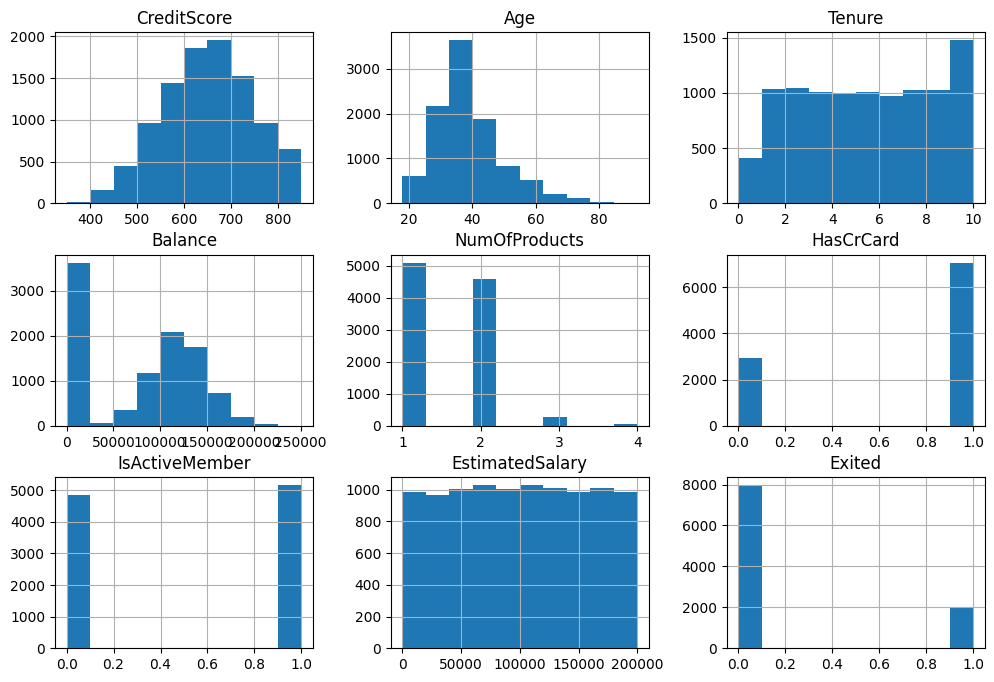

In [74]:
dataset.hist(figsize=(12,8))
plt.show()

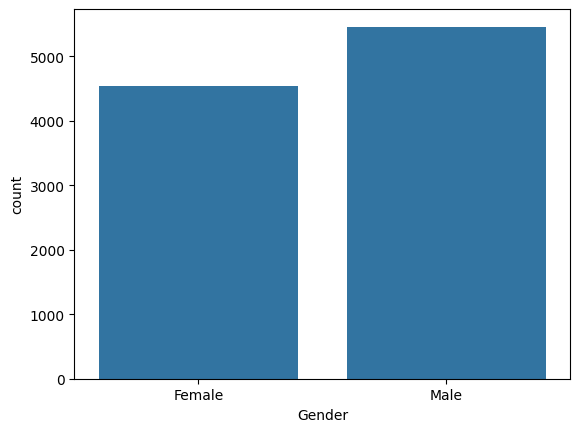

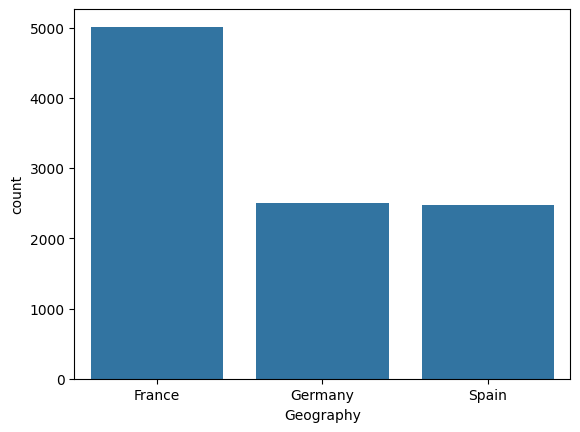

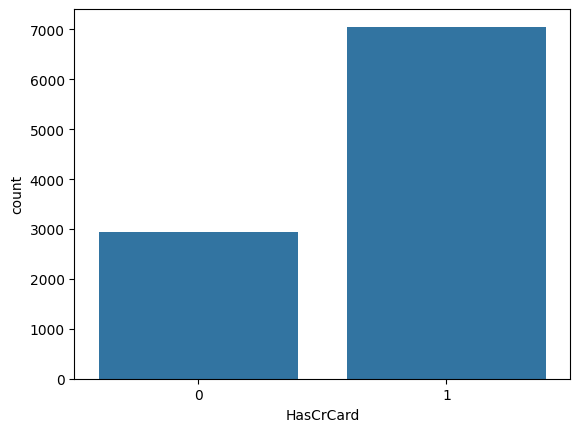

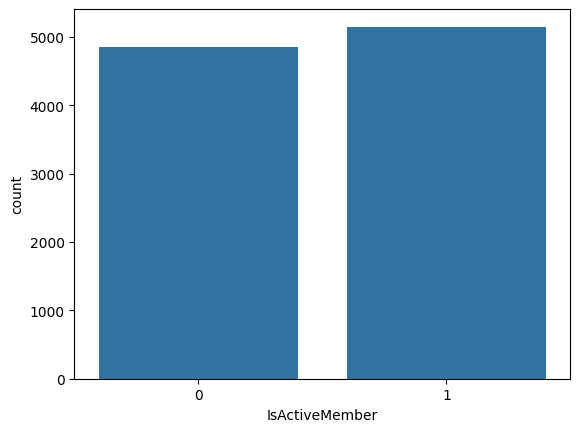

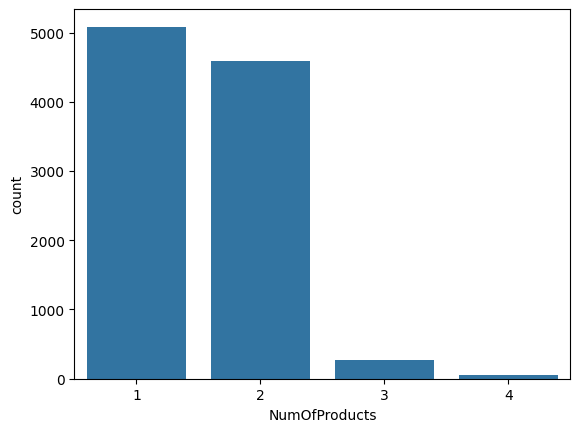

In [75]:
#Count Plots for Categorical Features
for col in ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']:
    sns.countplot(x=col, data=dataset)
    plt.show()

**Churn Analysis (Target = Exited)**

Churn Rate:
 Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


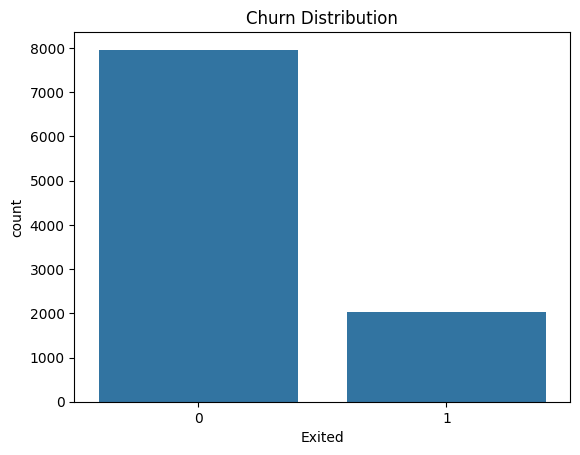

In [76]:
print("Churn Rate:\n", dataset['Exited'].value_counts(normalize=True))
sns.countplot(x='Exited', data=dataset)
plt.title("Churn Distribution")
plt.show()

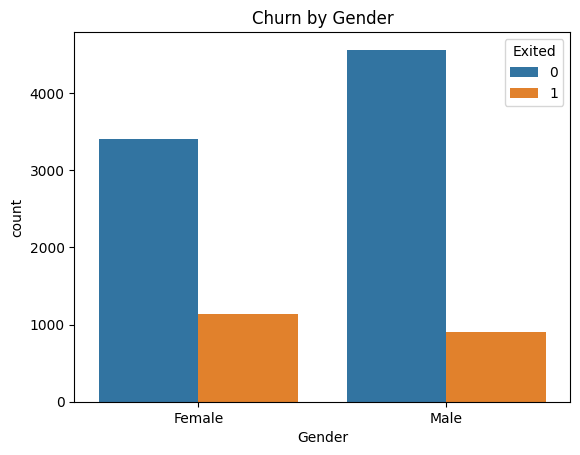

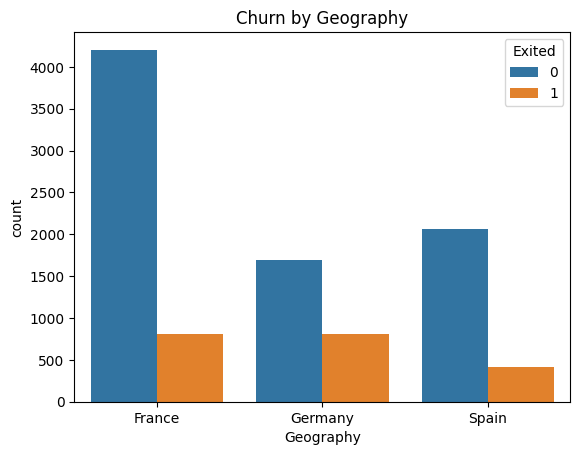

In [77]:
# Churn vs Gender
sns.countplot(x='Gender', hue='Exited', data=dataset)
plt.title("Churn by Gender")
plt.show()

# Churn vs Geography
sns.countplot(x='Geography', hue='Exited', data=dataset)
plt.title("Churn by Geography")
plt.show()

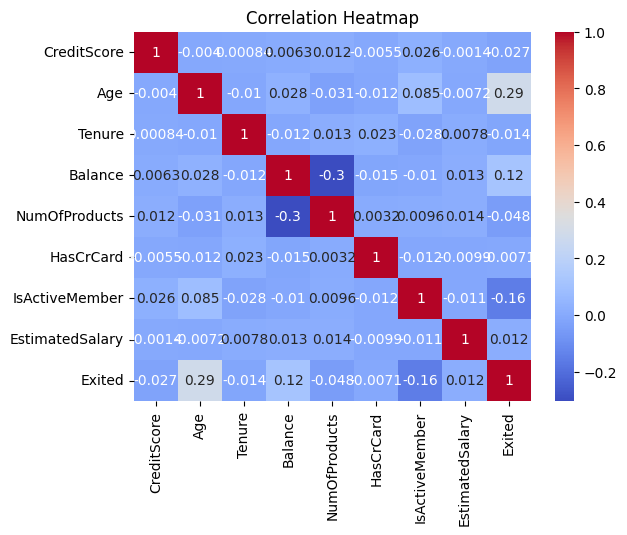

In [78]:
# Correlation Heatmap
corr = dataset.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

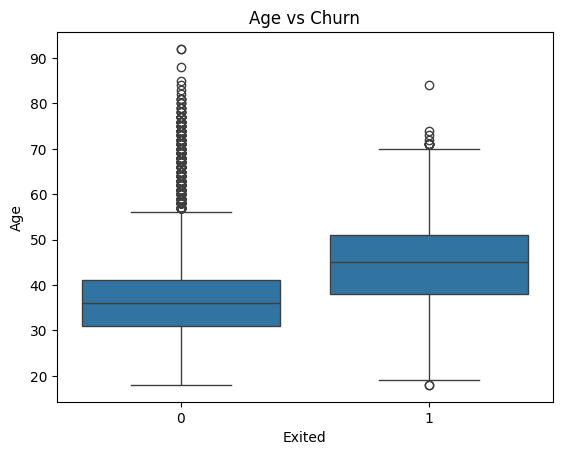

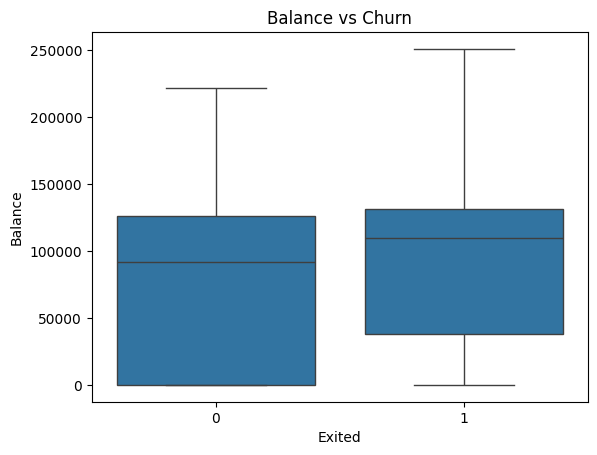

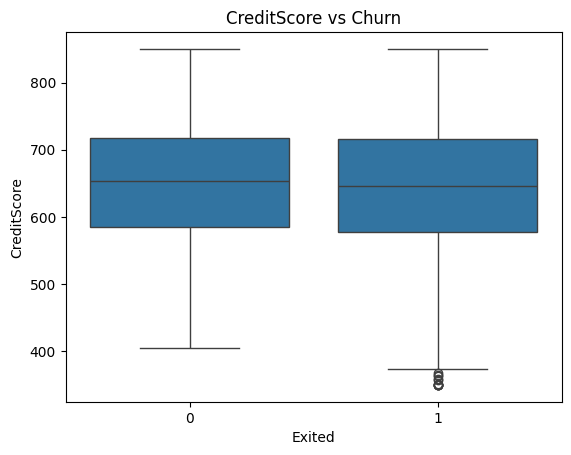

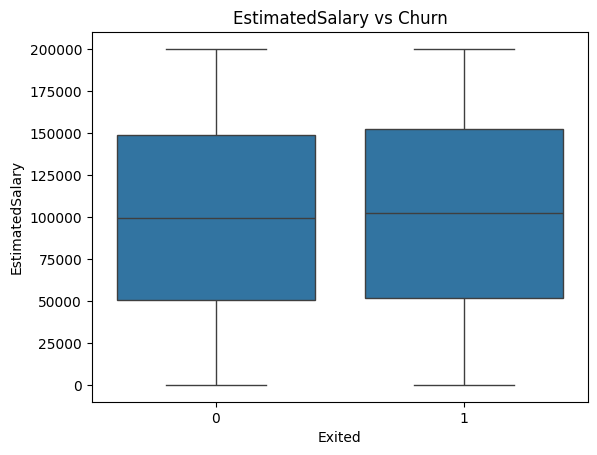

In [79]:
# Boxplots of Numerical vs Churn
for col in ['Age','Balance','CreditScore','EstimatedSalary']:
    sns.boxplot(x='Exited', y=col, data=dataset)
    plt.title(f"{col} vs Churn")
    plt.show()

# Data Preprocessing

In [80]:
# Separate features and target
X = dataset.drop('Exited', axis=1)
y = dataset['Exited']

# Identify categorical and numerical columns
categorical_cols = ['Gender', 'Geography']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [81]:
# One-Hot Encode categorical features (drop first to avoid dummy variable trap)
X = pd.get_dummies(X, columns=['Gender', 'Geography'], drop_first=True)

In [82]:
print("After encoding:")
X.head()

After encoding:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,False,True
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,False,True


**Gender**

Original: Female, Male

With drop_first=True → only Gender_Male remains

False = Female

True = Male

**Geography**

Original: France, Germany, Spain

With drop_first=True → Geography_Germany, Geography_Spain

Both False = France

True in Germany column = Germany

True in Spain column = Spain

In [83]:
scaler = StandardScaler()

X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [84]:
X['Gender_Male'] = X['Gender_Male'].astype(int)
X['Geography_Germany'] = X['Geography_Germany'].astype(int)
X['Geography_Spain'] = X['Geography_Spain'].astype(int)

In [85]:
print("After scaling:")
X.head()

After scaling:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,0,0,1
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,0,0,1


# Model Training

In [86]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 11)
Test shape: (2000, 11)


**1. Logistic Regression**

In [87]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
print("Logistic Regression Accuracy:")
print(accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

Logistic Regression Accuracy:
0.808
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

Confusion Matrix:
 [[1540   53]
 [ 331   76]]


**2. Random Forest**

In [88]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.8595
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000

Confusion Matrix:
 [[1534   59]
 [ 222  185]]


**3. XGBoost**

In [89]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.849
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.68      0.48      0.56       407

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

Confusion Matrix:
 [[1502   91]
 [ 211  196]]


# Predicting and Exporting

In [92]:
# Make Predictions & Probabilities
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

#Add CustomerId from original_df (align with X_test indices)
customer_ids = original_df.loc[X_test.index, "CustomerId"]

#Export Predictions + Probabilities with CustomerId
results = pd.DataFrame({
    "CustomerId": customer_ids,
    "Actual": y_test,
    "LogReg_Pred": y_pred_log,
    "LogReg_Prob": y_prob_log,
    "RF_Pred": y_pred_rf,
    "RF_Prob": y_prob_rf,
    "XGB_Pred": y_pred_xgb,
    "XGB_Prob": y_prob_xgb
})

results.to_csv("churn_predictions.csv", index=False)

**Save Feature Importances**

In [93]:
# Logistic Regression
log_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": log_model.coef_[0]
}).sort_values(by="Importance", key=abs, ascending=False)
log_importances.to_csv("log_reg_feature_importance.csv", index=False)

# Random Forest
rf_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
rf_importances.to_csv("rf_feature_importance.csv", index=False)

# XGBoost
xgb_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
xgb_importances.to_csv("xgb_feature_importance.csv", index=False)
